In [1]:
# Device specifications
!nvidia-smi

Sun Feb  6 11:53:27 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip -q install transformers

     |████████████████████████████████| 3.5 MB 5.1 MB/s 
     |████████████████████████████████| 67 kB 6.3 MB/s 
     |████████████████████████████████| 895 kB 76.2 MB/s 
     |████████████████████████████████| 6.8 MB 51.1 MB/s 
     |████████████████████████████████| 596 kB 47.5 MB/s 


In [3]:
import tensorflow, keras, transformers
print(f"tf version: {tensorflow.__version__}")
print(f"keras version: {keras.__version__}")
print(f"transformers version: {transformers.__version__}")

tf version: 2.7.0
keras version: 2.7.0
transformers version: 4.16.2


# Dependencies

In [4]:
import glob
import warnings
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

warnings.filterwarnings("ignore")

# Download data

In [5]:
# I will use only one third of the dataset to make the experimentation faster
!wget -P data/ https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_1.csv
# !wget -P data/ https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_2.csv
# !wget -P data/ https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_3.csv

--2022-02-06 11:53:44--  https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_1.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.98.128, 142.250.97.128, 142.251.107.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.98.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14174600 (14M) [application/octet-stream]
Saving to: ‘data/goemotions_1.csv’

goemotions_1.csv    100%[===================>]  13.52M  --.-KB/s    in 0.1s    

2022-02-06 11:53:44 (139 MB/s) - ‘data/goemotions_1.csv’ saved [14174600/14174600]



# Load data

In [6]:
labels = ['admiration', 'amusement', 'anger', 'annoyance', 'approval', 
          'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 
          'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 
          'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 
          'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 
          'neutral']

path_list = glob.glob("data/goemotions_*.csv", recursive=True)
dfs = [pd.read_csv(path, usecols=(['text'] + labels)) for path in path_list]
dataset = pd.concat(dfs)
# Shuffle
dataset = dataset.sample(frac=1).reset_index(drop=True)

print(f"Number of samples: {len(dataset)}")
print(f"Number of labels: {len(labels)}")
display(dataset.head())

Number of samples: 70000
Number of labels: 28


,text,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,disappointment,disapproval,disgust,embarrassment,excitement,fear,gratitude,grief,joy,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,is a recent article interesting read.,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,"I’ve learned to just laugh these off, and try ...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,Can you provide any evidence to your claim tha...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,how do you feel about the possibility of the c...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,i wear all black. always. i died when we launc...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Preprocessing

For now, the only preprocessing that we are going to do is lower casing all text and drop samples without text.

We can apply our preprocessing steps to our text feature in the dataframe by wrapping all these processes under a function.

In [7]:
dataset.dropna(subset=["text"], axis=0, inplace=True)
print(f"Number of samples: {len(dataset)}")

Number of samples: 70000


In [8]:
# Define preprocessing function
def preprocess(text, lower=True):
    if lower:
        text = text.lower()
    return text

In [9]:
# Apply to dataframe
dataset.text = dataset.text.apply(preprocess, lower=True)

# EDA

## Positive labels per text sample

**Question:** How many positive labels do each sample have on average? This might give an idea if samples have too many signals or not (many labels for each sample).

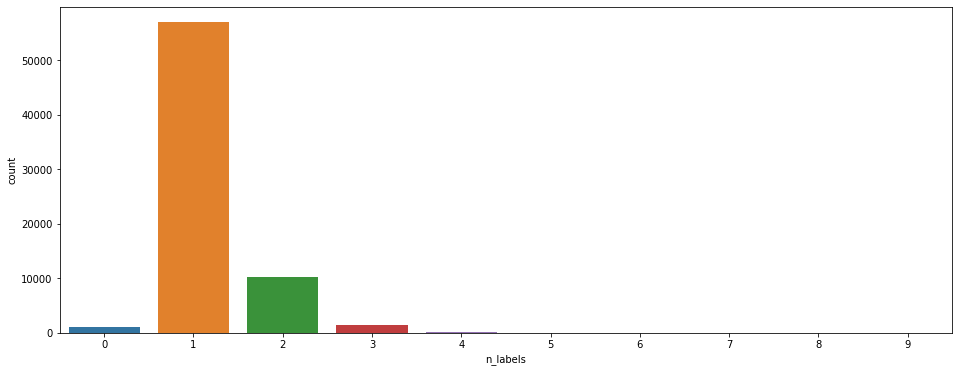

In [10]:
dataset['n_labels'] = dataset[labels].sum(axis=1)

plt.figure(figsize=(16, 6))
sns.countplot(x="n_labels", data=dataset)
plt.show()

## Label distribution

**Question:** How many samples do we have for each label? Which ones are more popular, and which ones might have too few samples?

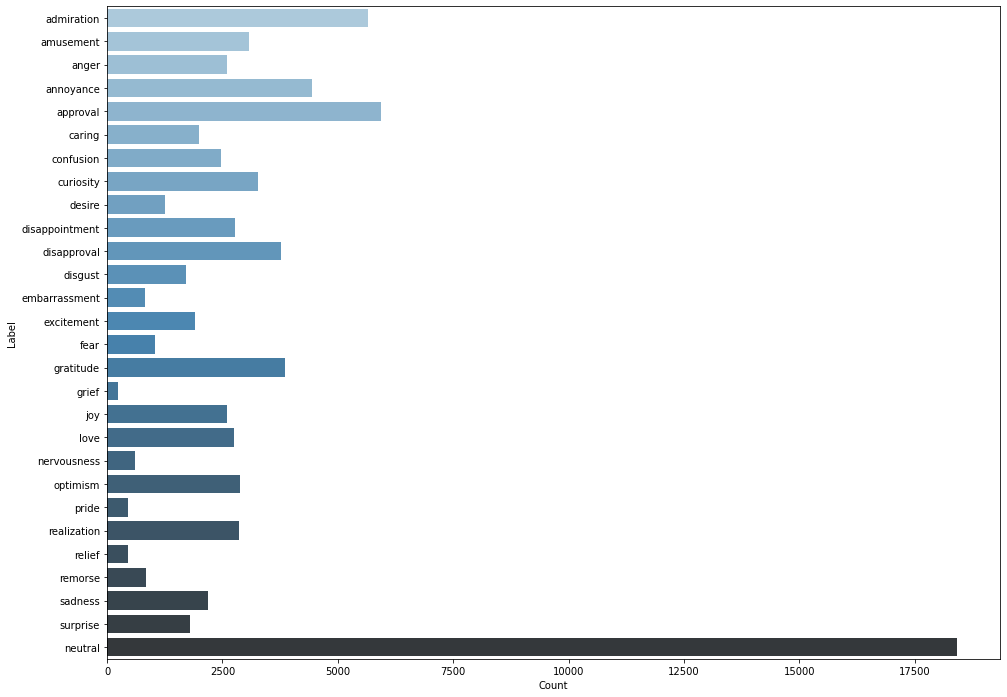

In [11]:
label_count = dataset[labels].agg({x:'sum' for x in labels}).reset_index()
label_count.columns = ['Label', 'Count']

plt.figure(figsize=(16, 12))
sns.barplot(x="Count", y="Label", data=label_count, palette="Blues_d")
plt.show()

## Text length

**Question:** How is distributed the size of our text samples? This could give us some insights if some samples might need to be truncated or if some of them are too small to have enough context.

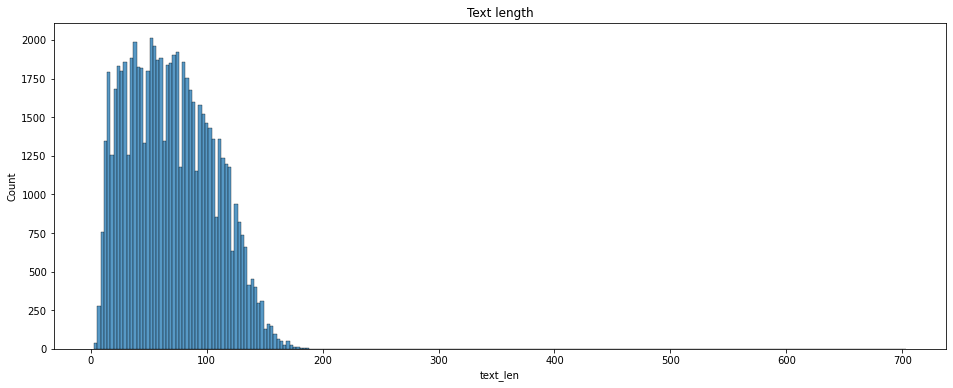

In [12]:
dataset["text_len"] = dataset["text"].apply(lambda x : len(x))

plt.figure(figsize=(16, 6))
sns.histplot(dataset['text_len']).set_title('Text length')
plt.show()

## Wordcloud

**Question:**  Is there enough signal in the text that is related to the label?

### Wordcloud for "gratitude"

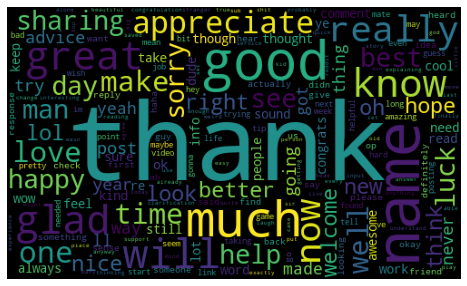

In [13]:
def display_word_cloud(df, label):
    plt.figure(figsize=(15, 5))
    subset = df[df[label] == 1]
    text = subset.text.values
    cloud = WordCloud(stopwords=STOPWORDS, background_color="black", 
                      collocations=False, width=500, 
                      height=300).generate(" ".join(text))
    plt.axis("off")
    plt.imshow(cloud)

display_word_cloud(dataset, label="gratitude")

### Wordcloud for "sadness"

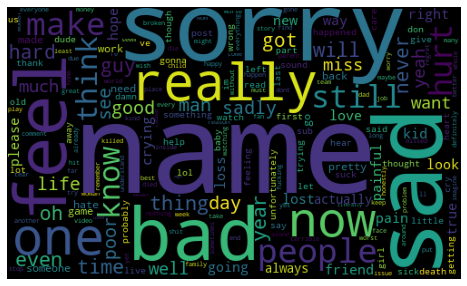

In [14]:
display_word_cloud(dataset, label="sadness")

# Dataset split

- Train (70%): 147857
- Validation (15%): 31684
- Test (15%): 31684

In [15]:
from sklearn.model_selection import train_test_split
seed = 42

In [16]:
X_train, X_test, y_train, y_test = train_test_split(dataset.text, dataset[labels], test_size=0.3, random_state=seed)
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.5, random_state=seed)

In [17]:
train_df = y_train.copy()
train_df["text"] = X_train
print(f"Train samples: {len(train_df)}")

valid_df = y_valid.copy()
valid_df["text"] = X_valid
print(f"Validation samples: {len(valid_df)}")

test_df = y_test.copy()
test_df["text"] = X_test
print(f"Test samples: {len(test_df)}")

Train samples: 49000
Validation samples: 10500
Test samples: 10500


In [18]:
# Save dataset
train_df.to_csv("data/train.csv", index=False)
test_df.to_csv("data/valid.csv", index=False)
train_df.to_csv("data/test.csv", index=False)

## Data distribution

### Complete dataset

Number of samples: 70000


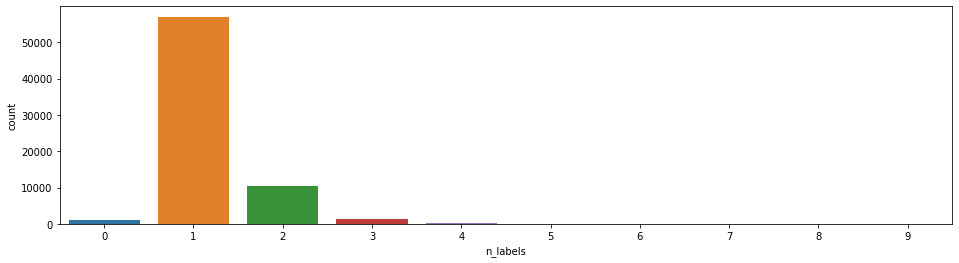

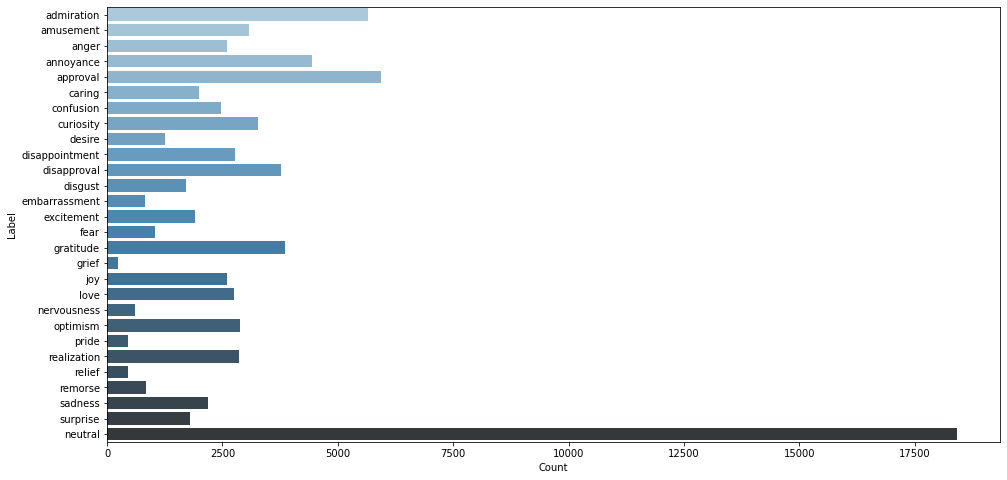

In [19]:
print(f"Number of samples: {len(dataset)}")

dataset['n_labels'] = dataset[labels].sum(axis=1)
plt.figure(figsize=(16, 4))
sns.countplot(x="n_labels", data=dataset)
plt.show()

label_count = dataset[labels].agg({x:'sum' for x in labels}).reset_index()
label_count.columns = ['Label', 'Count']
plt.figure(figsize=(16, 8))
sns.barplot(x="Count", y="Label", data=label_count, palette="Blues_d")
plt.show()

### Train dataset

Number of samples: 49000


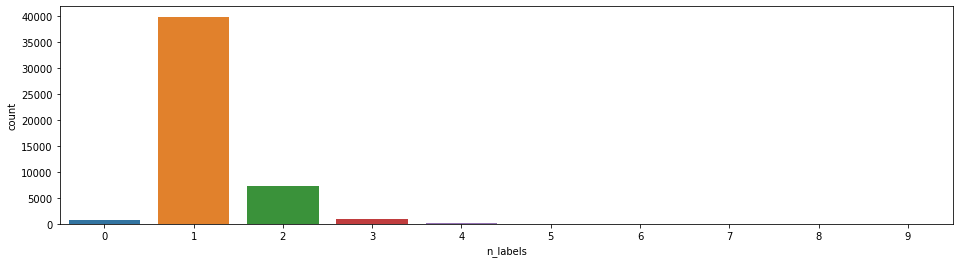

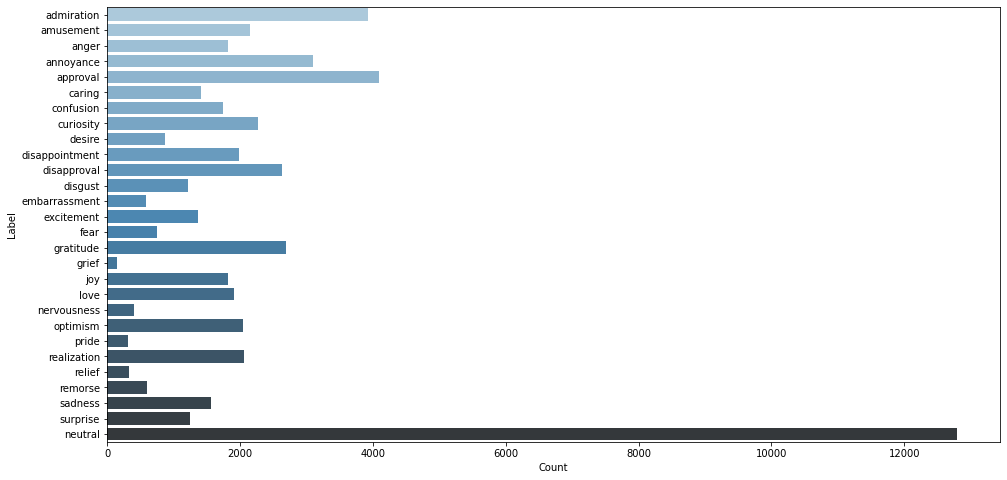

In [20]:
print(f"Number of samples: {len(train_df)}")

train_df['n_labels'] = train_df[labels].sum(axis=1)
plt.figure(figsize=(16, 4))
sns.countplot(x="n_labels", data=train_df)
plt.show()

train_label_count = train_df[labels].agg({x:'sum' for x in labels}).reset_index()
train_label_count.columns = ['Label', 'Count']
plt.figure(figsize=(16, 8))
sns.barplot(x="Count", y="Label", data=train_label_count, palette="Blues_d")
plt.show()

### Validation dataset

Number of samples: 10500


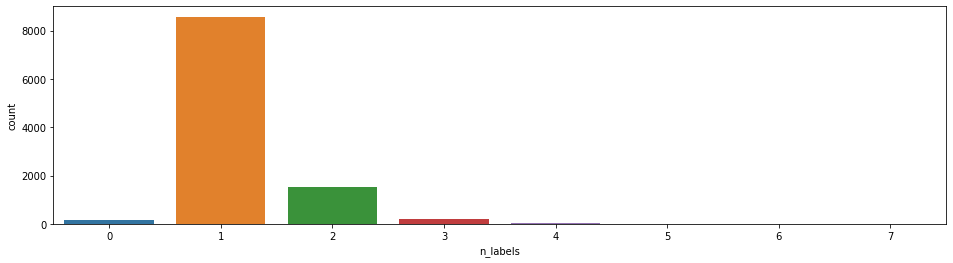

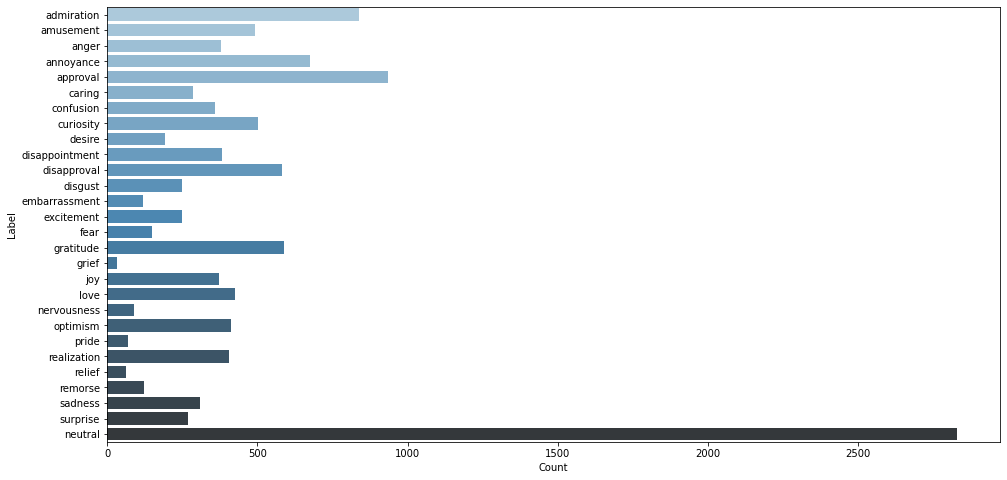

In [21]:
print(f"Number of samples: {len(valid_df)}")

valid_df['n_labels'] = valid_df[labels].sum(axis=1)
plt.figure(figsize=(16, 4))
sns.countplot(x="n_labels", data=valid_df)
plt.show()

valid_label_count = valid_df[labels].agg({x:'sum' for x in labels}).reset_index()
valid_label_count.columns = ['Label', 'Count']
plt.figure(figsize=(16, 8))
sns.barplot(x="Count", y="Label", data=valid_label_count, palette="Blues_d")
plt.show()

### Test dataset

Number of samples: 10500


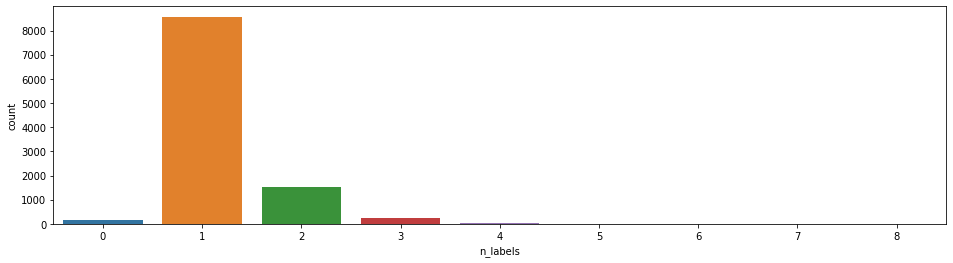

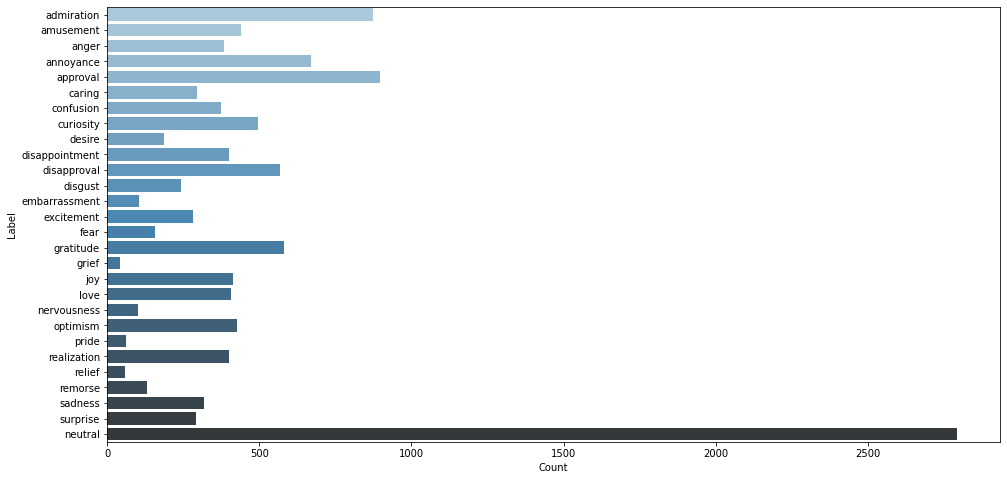

In [22]:
print(f"Number of samples: {len(test_df)}")

test_df['n_labels'] = test_df[labels].sum(axis=1)
plt.figure(figsize=(16, 4))
sns.countplot(x="n_labels", data=test_df)
plt.show()

test_label_count = test_df[labels].agg({x:'sum' for x in labels}).reset_index()
test_label_count.columns = ['Label', 'Count']
plt.figure(figsize=(16, 8))
sns.barplot(x="Count", y="Label", data=test_label_count, palette="Blues_d")
plt.show()

# Modeling

In [23]:
import random, os, json
import numpy as np
import tensorflow as tf
from sklearn.metrics import precision_recall_fscore_support

def set_seeds(seed=1234):
    """Set seeds for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

## Random

motivation: We want to know what random (chance) performance looks like. All of our subsequent baselines should perform better than this.

In [24]:
# Set seeds
set_seeds(seed)

In [25]:
# Generate random predictions
y_pred = np.random.randint(low=0, high=2, size=(len(test_df), len(labels)))
print(y_pred.shape)
print(y_pred[:5])

(10500, 28)
[[0 1 0 0 0 1 0 0 0 1 0 0 0 0 1 0 1 1 1 0 1 0 1 1 1 1 1 1]
 [1 1 0 0 1 1 1 0 1 0 0 0 0 0 1 1 1 1 1 0 1 1 0 1 0 1 0 1]
 [1 0 0 0 0 0 0 0 0 1 1 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 1]
 [0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 0 1 0]
 [1 1 0 1 0 1 1 0 1 0 1 0 0 1 1 0 1 1 1 0 0 0 0 0 0 0 0 0]]


### Evaluation

In [26]:
metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
performance = {"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}
print(json.dumps(performance, indent=2))

{
  "precision": 0.09861063487383571,
  "recall": 0.502540527461892,
  "f1": 0.1468771851187924
}


We made the assumption that there is an equal probability for whether an input has an emotion or not, but this isn't true. Let's use the train split to figure out what the true probability is.



In [27]:
# Percentage of 1s (tag presence)
tag_p = np.sum(np.sum(y_train)) / (len(y_train) * len(labels))
print(tag_p)

0.042171282798833816


In [28]:
# Generate weighted random predictions
y_pred = np.random.choice(
    np.arange(0, 2), size=(len(y_test), len(labels)),
    p=[1-tag_p, tag_p])

In [29]:
# Validate percentage
np.sum(np.sum(y_pred)) / (len(y_pred) * len(labels))

0.04229931972789116

### Evaluation

In [30]:
metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
performance = {"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}
print(json.dumps(performance, indent=2))

{
  "precision": 0.09483233304948627,
  "recall": 0.0446003709976611,
  "f1": 0.051527428014969616
}


**limitations:** we didn't use any of the signals from our inputs to affect our predictions, so nothing was learned.



## Rule-based

motivation: we want to use signals in our inputs (along with domain expertise and auxiliary data) to determine the labels.

### Top-K words

Usually in texts, emotions are heavily correlated with the occurrences of a few words that gives drives the main emotion of that text, sometimes that words can be the emotions themselves, let's try to predict the labels looking if a piece of text contains words that are commonly found in other texts with the same emotions.

**Domain knowledge**: This dataset has anonymized names, so instead of a person's name we have `[name]` instead, this adds no value to our predictions, so let's also remove this from the top-K words

In [31]:
from pprint import pprint
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop = stopwords.words('english')
stop.append("[name]")
stop.append("[name].")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [32]:
def get_top_k_words(dataset, k=15, label="love"):
    label_text = dataset[dataset[label] == 1].text
    clean_text = label_text.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
    top_k_words = pd.Series(' '.join(clean_text).split()).value_counts().index[:k]
    return list(top_k_words)

In [33]:
# Top-15 words for "grief"
print(get_top_k_words(train_df, k=15, label="grief"))

['died', 'sorry', 'people', 'one', 'i’m', 'like', 'loss.', 'dead.', 'feel', 'get', 'poor', "i'm", 'life', 'death', 'you.']


In [34]:
# Top-15 words for "love"
print(get_top_k_words(train_df, k=15, label="love"))

['love', 'like', 'it.', 'would', 'loved', 'really', 'one', 'favorite', "i'm", 'people', 'see', 'get', 'much', 'still', 'loves']


In [35]:
# Create a dict with top-K words for each label
def get_top_words_dict(dataset, labels=labels, k=15):
    return {label:get_top_k_words(train_df, k=k, label=label) for label in labels}

In [36]:
top_words_dict = get_top_words_dict(train_df)
pprint(top_words_dict)

{'admiration': ['good',
                'like',
                'great',
                'love',
                'one',
                'really',
                'pretty',
                'best',
                "that's",
                'nice',
                'would',
                'amazing',
                "i'm",
                'get',
                'looks'],
 'amusement': ['lol',
               'like',
               'lol.',
               'haha',
               'funny',
               'lmao',
               'fun',
               "i'm",
               'people',
               'would',
               'one',
               'got',
               'it’s',
               "that's",
               'think'],
 'anger': ['fuck',
           'hate',
           'like',
           'people',
           'get',
           'fucking',
           'one',
           'really',
           'would',
           "i'm",
           'even',
           'stop',
           'damn',
           'stupid',
         

Some words are too common and appear in many different labels, let's remove those words that appear in at least 20% of the total labels.

In [37]:
from collections import Counter

label_words = []
for words in top_words_dict.values():
    label_words.extend(words)

label_counts = Counter(label_words)
print(label_counts)

Counter({'like': 28, "i'm": 28, 'get': 25, 'would': 24, 'one': 22, 'really': 20, 'people': 19, 'i’m': 14, "that's": 12, 'think': 11, 'good': 10, 'know': 10, 'even': 9, 'see': 9, 'still': 9, 'love': 8, 'feel': 8, 'it’s': 6, 'bad': 6, 'oh': 6, 'never': 5, 'got': 4, 'make': 4, 'it.': 4, 'hope': 4, 'you.': 4, 'sorry': 4, 'glad': 4, 'don’t': 3, 'want': 3, 'great': 2, 'fun': 2, 'fuck': 2, 'hate': 2, 'fucking': 2, 'need': 2, 'go': 2, 'wish': 2, 'weird': 2, 'happy': 2, 'thank': 2, ':)': 2, 'much': 2, 'better': 2, 'time': 2, 'pretty': 1, 'best': 1, 'nice': 1, 'amazing': 1, 'looks': 1, 'lol': 1, 'lol.': 1, 'haha': 1, 'funny': 1, 'lmao': 1, 'stop': 1, 'damn': 1, 'stupid': 1, 'take': 1, 'keep': 1, 'sure': 1, 'maybe': 1, 'understand': 1, 'curious': 1, '[name]?': 1, 'could': 1, 'wanted': 1, "can't": 1, 'way': 1, 'worst': 1, 'awful': 1, 'shame': 1, 'excited': 1, 'new': 1, 'afraid': 1, 'scared': 1, 'terrible': 1, 'scary': 1, 'makes': 1, 'horrible': 1, 'thanks': 1, 'thanks!': 1, 'you!': 1, 'appreciate'

In [38]:
words_to_remove = []
for word, cnt in label_counts.items():
    if cnt >= (len(labels) * 0.4):
      words_to_remove.append(word)
print(words_to_remove)

['like', 'one', 'really', "that's", 'would', "i'm", 'get', 'people', 'i’m']


In [39]:
for key, value in top_words_dict.items():
    top_words_dict[key] = [word for word in value if word not in words_to_remove]
pprint(top_words_dict)

{'admiration': ['good',
                'great',
                'love',
                'pretty',
                'best',
                'nice',
                'amazing',
                'looks'],
 'amusement': ['lol',
               'lol.',
               'haha',
               'funny',
               'lmao',
               'fun',
               'got',
               'it’s',
               'think'],
 'anger': ['fuck',
           'hate',
           'fucking',
           'even',
           'stop',
           'damn',
           'stupid',
           'don’t'],
 'annoyance': ['even', 'know', 'fuck', 'fucking', 'think', 'want', 'make'],
 'approval': ['good', 'think', 'it.', 'love', 'see', 'it’s', 'still'],
 'caring': ['good',
            'hope',
            'feel',
            'take',
            'love',
            'need',
            'you.',
            'keep',
            'go',
            'make'],
 'confusion': ['know',
               'think',
               'sure',
               'do

In [40]:
# Prediction
def predict_top_k(input, labels=labels, labels_dict=top_words_dict):
    y_pred = []
    for text in input:
        preds = []
        for label in labels:
            if any(word in text.split() for word in labels_dict[label]):
                preds.append(1)
            else:
                preds.append(0)
        y_pred.append(preds)
    return y_pred

y_pred = predict_top_k(X_test)

### Evaluation

In [41]:
metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
performance = {"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}
print(json.dumps(performance, indent=2))

{
  "precision": 0.16045650206347792,
  "recall": 0.30825066537624,
  "f1": 0.18502045988040355
}


### Inference

In [42]:
def inference_top_k(input, labels=labels, labels_dict=top_words_dict):
    preds = {}
    for label in labels:
        if any(word in input.split() for word in labels_dict[label]):
            preds[label] = 1
        else:
            preds[label] = 0
    return preds

text = "I am loving this amazing MLOps tutorial, so much cool content"
pprint(inference_top_k(text))

{'admiration': 1,
 'amusement': 0,
 'anger': 0,
 'annoyance': 0,
 'approval': 0,
 'caring': 0,
 'confusion': 0,
 'curiosity': 0,
 'desire': 0,
 'disappointment': 0,
 'disapproval': 0,
 'disgust': 0,
 'embarrassment': 0,
 'excitement': 0,
 'fear': 0,
 'gratitude': 1,
 'grief': 0,
 'joy': 0,
 'love': 1,
 'nervousness': 0,
 'neutral': 0,
 'optimism': 0,
 'pride': 0,
 'realization': 0,
 'relief': 0,
 'remorse': 0,
 'sadness': 0,
 'surprise': 0}


**limitations:** we failed to generalize or learn any implicit patterns to predict the labels because we are trying to predict by using the words themselves, and we do not capture text context or intention, where most of the emotion would be captured.

> We could further improve this approach by using more preprocessing like removing punctuation or using top-k words that are more unique for each label, applying maybe normalization similar to TF-IDF.

## Simple ML

**motivation:**
- **representation:** use term frequency-inverse document frequency (TF-IDF) to capture the significance of a token to a particular input with respect to all the inputs, as opposed to treating the words in our input text as isolated tokens.
- **architecture:** we want our model to meaningfully extract the encoded signal to predict the output labels.

So far, we've treated the words in our input text as isolated tokens, and we haven't really captured any meaning between tokens. Let's use term frequency–inverse document frequency (TF-IDF) to capture the significance of a token to a particular input with respect to all the inputs.

In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC

In [44]:
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import MultiLabelBinarizer

In [45]:
# Tf-idf
vectorizer = TfidfVectorizer()
print(X_train.iloc[0])
X_train_tfidf = vectorizer.fit_transform(X_train)
X_valid_tfidf = vectorizer.transform(X_valid)
X_test_tfidf = vectorizer.transform(X_test)
print(X_train_tfidf.shape)
print(X_train_tfidf[0]) # scipy.sparse.csr_matrix

how do you deal with alerts coming up on your phone? i guess you can just turn them off?
(49000, 23869)
  (0, 14572)	0.2306277829655209
  (0, 21126)	0.198252003677551
  (0, 21904)	0.3077197195662827
  (0, 11634)	0.1522412920109867
  (0, 3481)	0.16580296286339563
  (0, 9565)	0.2590632099051687
  (0, 15620)	0.305716381179493
  (0, 23764)	0.16725556447319567
  (0, 14681)	0.15301341004241464
  (0, 22405)	0.18860382687821856
  (0, 4490)	0.2840325189876796
  (0, 1073)	0.46082726161615817
  (0, 23401)	0.15657814581045604
  (0, 5660)	0.2874794788967969
  (0, 23754)	0.22034462690577664
  (0, 6521)	0.17920647108543936
  (0, 10416)	0.18370685533024808


In [46]:
def fit_and_evaluate(model):
    """Fit and evaluate each model."""
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)
    metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
    return {"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}

In [47]:
  # Models
performance = {}
performance["logistic-regression"] = fit_and_evaluate(OneVsRestClassifier(
    LogisticRegression(), n_jobs=1))

performance["support-vector-machine"] = fit_and_evaluate(OneVsRestClassifier(
    LinearSVC(), n_jobs=-1))

print(json.dumps(performance, indent=2))

{
  "logistic-regression": {
    "precision": 0.5315480794859421,
    "recall": 0.10758932171949351,
    "f1": 0.1586373601997166
  },
  "support-vector-machine": {
    "precision": 0.44412195169778695,
    "recall": 0.18840229050729898,
    "f1": 0.2510807956403342
  }
}


**limitations:**

- **representation:** TF-IDF representations don't encapsulate much signal beyond frequency, but we require more fine-grained token representations.
- **architecture:** we want to develop models that can use better represented encodings in a more contextual manner

## CNN w/ Embeddings

**motivation:**

- **representation**: we want to have more robust (split tokens to characters) and meaningful embedding-based representations for our input tokens.
- **architecture**: we want to process our encoded inputs using convolution (CNN) filters that can learn to analyze windows of embedded tokens to extract meaningful signal.

### Set up

In [48]:
import tensorflow.keras.layers as L

# Looking at the "EDA" part, 128 length should cover most samples.
max_seq_len = 128

### Tokenizer

We're going to tokenize our input text as character tokens, so we can be robust to spelling errors and learn to generalize across words.

In [49]:
# Define split strategy
@tf.keras.utils.register_keras_serializable()
def cnn_split(text):
  return tf.strings.unicode_split(text, 'UTF-8')

# Define standardization strategy
@tf.keras.utils.register_keras_serializable()
def cnn_standardization(text):
    lowercased = tf.strings.lower(text)
    return lowercased

# Create a TextVectorization layer
text_vectorizer = L.TextVectorization(
    standardize=cnn_standardization, 
    split=cnn_split, 
    output_mode="int",
    output_sequence_length=max_seq_len
)

In [50]:
# Tokenize
text_vectorizer.adapt(X_train.values)

vocab = text_vectorizer.get_vocabulary()
print(f"Vocabulary size: {len(vocab)}")
print(vocab)

Vocabulary size: 434
['', '[UNK]', ' ', 'e', 't', 'o', 'a', 'i', 'n', 's', 'h', 'r', 'l', 'd', 'u', 'm', 'y', 'g', 'c', 'w', '.', 'p', 'f', 'b', 'k', 'v', "'", ',', '!', '[', ']', '’', 'j', '?', 'x', '"', '0', 'z', '-', '*', '1', ':', '2', 'q', '/', ')', '3', '(', '5', '>', '4', '9', '“', '”', '6', '8', '7', '^', '😂', '~', ';', '%', '$', '⠀', '#', '+', '️', '|', '_', '<', '=', '&', '❤', '‘', '🤣', '😤', '🦀', '👏', '\u200d', '⣿', '😭', '@', '🤔', '🏼', '🏻', '🤷', '♀', '😅', '🙏', '💜', '⠛', '—', '😉', '👌', '😍', '😊', '👍', 'é', '😡', '😎', '😢', '¯', '£', '🙄', '😏', '♥', '♂', '⣤', '⣀', '☹', '😁', '💦', '🌈', '™', '😩', '🔥', '⠶', '☺', '😄', '€', '💖', '🏳', '🤦', '🤢', '😘', 'ツ', '⢀', '͡', '°', '😔', '💕', '👀', '⠉', 'ɪ', '🤗', '🙌', '😐', '😆', '💪', '⣶', 'ᴛ', 'ᴏ', '🤮', '😬', '⠋', '⠃', '⠁', '͜', 'ʖ', 'á', '`', '🤙', '😳', '😥', '😕', '😇', '😀', '🔪', '💯', '🎶', '🎉', '🅱', '⣄', '⡟', '✔', '☁', '…', 'ᴀ', '´', '\\', '🤪', '🤞', '😱', '😒', '💨', '💅', '🏽', '⢠', '⡀', '❣', '🤬', '🤩', '🤚', '🙈', '😮', '😣', '😜', '😖', '🖐', '💙', '💓', '👋', '👊', '👇',

In [51]:
print ("Text to indices:\n"
    f"(preprocessed) → {X_train.iloc[0]}\n"
    f"(tokenized) → {text_vectorizer(X_train.iloc[0]).numpy()}")

Text to indices:
(preprocessed) → how do you deal with alerts coming up on your phone? i guess you can just turn them off?
(tokenized) → [10  5 19  2 13  5  2 16  5 14  2 13  3  6 12  2 19  7  4 10  2  6 12  3
 11  4  9  2 18  5 15  7  8 17  2 14 21  2  5  8  2 16  5 14 11  2 21 10
  5  8  3 33  2  7  2 17 14  3  9  9  2 16  5 14  2 18  6  8  2 32 14  9
  4  2  4 14 11  8  2  4 10  3 15  2  5 22 22 33  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]


### Data imbalance

We'll factor class weights in our objective function ([binary cross entropy with logits](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html)) to help with [class imbalance](https://madewithml.com/courses/mlops/labeling/#data-imbalance). There are many other techniques such as over sampling from underrepresented classes, undersampling, etc. but we'll cover these in a separate unit lesson on data imbalance

In [52]:
# Class weights
counts = [len(train_df[train_df[label] == 1]) for label in labels]
class_weights = {i: 1.0/count for i, count in enumerate(counts)}
print (f"class counts: {counts},\nclass weights: {class_weights}")

class counts: [3934, 2148, 1825, 3095, 4096, 1409, 1740, 2269, 866, 1986, 2626, 1211, 592, 1368, 744, 2691, 153, 1822, 1911, 409, 2048, 321, 2061, 331, 594, 1565, 1245, 12799],
class weights: {0: 0.0002541942043721403, 1: 0.0004655493482309125, 2: 0.000547945205479452, 3: 0.00032310177705977385, 4: 0.000244140625, 5: 0.0007097232079489, 6: 0.0005747126436781609, 7: 0.00044072278536800354, 8: 0.0011547344110854503, 9: 0.0005035246727089627, 10: 0.0003808073115003808, 11: 0.0008257638315441783, 12: 0.0016891891891891893, 13: 0.0007309941520467836, 14: 0.0013440860215053765, 15: 0.0003716090672612412, 16: 0.006535947712418301, 17: 0.0005488474204171241, 18: 0.0005232862375719519, 19: 0.0024449877750611247, 20: 0.00048828125, 21: 0.003115264797507788, 22: 0.00048520135856380397, 23: 0.0030211480362537764, 24: 0.0016835016835016834, 25: 0.0006389776357827476, 26: 0.0008032128514056225, 27: 7.813110399249941e-05}


### Datasets

Here we are going to use [TF.data.Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) to efficiently load and process data for training, evaluation, and inference.

In [53]:
def get_dataset(x, y, labels=labels, labeled=True, ordered=False, 
                repeated=True, batch_size=64):
    if labeled:
        dataset = tf.data.Dataset.from_tensor_slices((x, y))
    else:
        dataset = tf.data.Dataset.from_tensor_slices(x)
  
    if repeated:
        dataset = dataset.repeat()
    if not ordered:
        dataset = dataset.shuffle(2048)
        
    dataset = dataset.batch(batch_size)
    dataset = dataset.cache()
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

In [54]:
# Create datasets
cnn_train_dataset = get_dataset(train_df.text, train_df[labels])
cnn_valid_dataset = get_dataset(valid_df.text, valid_df[labels], ordered=True, repeated=False)
cnn_test_dataset = get_dataset(test_df.text, test_df[labels], ordered=True, repeated=False)

for sample in cnn_train_dataset.take(1):
    x = sample[0]
    y = sample[1]
    print("Sample point:\n"
    f"  X: {x[0].numpy().decode()}\n"
    f"  y: {y[0].numpy()}"
    )
    print("Sample shape:\n"
    f"  X: {x.shape}\n"
    f"  y: {y.shape}"
    )

Sample point:
  X: thank you for sharing your experience. it adds much needed hope.
  y: [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
Sample shape:
  X: (64,)
  y: (64, 28)


### Model

We'll be using a convolutional neural network on top of our embedded tokens to extract meaningful spatial signal. This time, we'll be using many filter widths to act as n-gram feature extractors.

![](https://github.com/dimitreOliveira/EmoBERT-MLOps/blob/main/assets/cnn_model_1.gif?raw=true)
> Image source: https://madewithml.com/courses/mlops/baselines/#model

Let's visualize the model's forward pass.

1. We'll first tokenize our inputs (batch_size, max_seq_len).
2. Then we'll embed our tokenized inputs (batch_size, max_seq_len, embedding_dim).
3. We'll apply convolution via filters (filter_size, embedding_dim, num_filters) followed by batch normalization. Our filters act as character level n-gram detectors. We have three different filter sizes (2, 3 and 4) and they will act as bi-gram, tri-gram and 4-gram feature extractors, respectively.
4. We'll apply 1D global max pooling, which will extract the most relevant information from the feature maps for making the decision.
5. We feed the pool outputs to a fully-connected (FC) layer (with dropout).
6. We use one more FC layer with softmax to derive class probabilities.

![](https://github.com/dimitreOliveira/EmoBERT-MLOps/blob/main/assets/cnn_model_2.png?raw=true)
> Image source: https://madewithml.com/courses/mlops/baselines/#model

In [55]:
# Arguments
embedding_dim = 128
num_filters = 128
hidden_dim = 128
dropout_p = 0.5
filter_sizes = [2, 3, 4]

In [56]:
def model_fn(tokenizer, num_classes, embedding_dim, filter_sizes, 
                 num_filters, hidden_dim, dropout_p):
    inputs = tf.keras.Input(shape=(1,), dtype=tf.string, name='text')
    token_x = tokenizer(inputs)

    emb_x = L.Embedding(input_dim=len(tokenizer.get_vocabulary()),
                        output_dim=embedding_dim)(token_x)

    convs = [L.Conv1D(filters=num_filters, 
                      kernel_size=f, 
                      activation='relu', 
                      padding='same') for f in filter_sizes]
    b_norms = [L.BatchNormalization() for _ in filter_sizes]
    max_pooling = L.MaxPool1D(num_filters)

    x_conv = []
    for i, f in enumerate(filter_sizes):
        # Conv
        _x_conv = convs[i](emb_x)

        # Batch norm
        _x_conv = b_norms[i](_x_conv)

        # Pool
        _x_conv = max_pooling(_x_conv)
        _x_conv = tf.squeeze(_x_conv, axis=1)
        x_conv.append(_x_conv)

    x_concat = tf.concat(x_conv, axis=-1)
    fc_x = L.Dropout(dropout_p)(x_concat)
    fc_x = L.Dense(hidden_dim)(fc_x)
    outputs = L.Dense(num_classes, activation='sigmoid')(fc_x)

    model = tf.keras.Model(inputs, outputs)
    return model

- **VALID**: no padding, the filters only use the "valid" values in the input. If the filter cannot reach all the input values (filters go left to right), the extra values on the right are dropped.
- **SAME**: adds padding evenly to the right (preferred) and left sides of the input so that all values in the input are processed.

![](https://github.com/dimitreOliveira/EmoBERT-MLOps/blob/main/assets/cnn_model_3.png?raw=true)
> Image source: https://madewithml.com/courses/mlops/baselines/#model


We're usin SAME padding so that the convolutional outputs are the same shape as our inputs. The amount of padding for the SAME padding can be determined using the same equation. We want our output to have the same width as our input, so we solve for P:

 
If  is not a whole number, we round up (using math.ceil) and place the extra padding on the right side.

As you can see we are using the **tokenizer as part of our model graph**, this has many advantages, specially considering deployment and serving, with this setup we don't have two moving pieces (model and tokenizer), here they are fused as one, thus we only care to train, store, deploy and monitor a single piece. Another advantage is that this way we can **feed the mode raw strings** instead of tokenized inputs.

In [57]:
# Initialize model
cnn_model = model_fn(text_vectorizer, len(labels), embedding_dim, filter_sizes, 
                     num_filters, hidden_dim, dropout_p)
cnn_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 text_vectorization (TextVector  (None, 128)         0           ['text[0][0]']                   
 ization)                                                                                         
                                                                                                  
 embedding (Embedding)          (None, 128, 128)     55552       ['text_vectorization[0][0]']     
                                                                                                  
 conv1d (Conv1D)                (None, 128, 128)     32896       ['embedding[0][0]']          

### Training

In [58]:
def get_strategy():
    # TPU or GPU detection
    # Detect hardware, return appropriate distribution strategy
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print(f'Running on TPU {tpu.master()}')
    except ValueError:
        tpu = None

    if tpu:
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.experimental.TPUStrategy(tpu)
    else:
        strategy = tf.distribute.get_strategy()
    return strategy

In [59]:
strategy = get_strategy()

In [60]:
# Arguments
lr = 2e-4
num_epochs = 15
steps_per_epoch = 500
patience = 3

In [61]:
# Define loss & metrics
loss_fn = tf.keras.losses.BinaryCrossentropy()
metrics_fn = tf.keras.metrics.BinaryAccuracy()

In [62]:
# Define optimizer & scheduler
optimizer = tf.keras.optimizers.Adam(lr=lr)
scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                 mode='min', factor=0.1, 
                                                 patience=patience, verbose=1)

In [63]:
# Compile model
cnn_model.compile(optimizer=optimizer, 
                  loss=loss_fn, 
                  metrics=metrics_fn)

In [64]:
# Train
with strategy.scope():
    cnn_model.fit(x=cnn_train_dataset, 
                  validation_data=cnn_valid_dataset, 
                  steps_per_epoch=steps_per_epoch, 
                  callbacks=[scheduler], 
                  epochs=num_epochs, 
                  class_weight=class_weights, 
                  verbose=2)

Epoch 1/15
500/500 - 18s - loss: 1.0632e-04 - binary_accuracy: 0.9427 - val_loss: 0.2840 - val_binary_accuracy: 0.9579 - lr: 2.0000e-04 - 18s/epoch - 36ms/step
Epoch 2/15
500/500 - 8s - loss: 7.8150e-05 - binary_accuracy: 0.9578 - val_loss: 0.1632 - val_binary_accuracy: 0.9582 - lr: 2.0000e-04 - 8s/epoch - 15ms/step
Epoch 3/15
500/500 - 8s - loss: 7.5372e-05 - binary_accuracy: 0.9582 - val_loss: 0.1594 - val_binary_accuracy: 0.9590 - lr: 2.0000e-04 - 8s/epoch - 15ms/step
Epoch 4/15
500/500 - 8s - loss: 7.3373e-05 - binary_accuracy: 0.9585 - val_loss: 0.1576 - val_binary_accuracy: 0.9592 - lr: 2.0000e-04 - 8s/epoch - 15ms/step
Epoch 5/15
500/500 - 8s - loss: 7.1152e-05 - binary_accuracy: 0.9588 - val_loss: 0.1536 - val_binary_accuracy: 0.9595 - lr: 2.0000e-04 - 8s/epoch - 15ms/step
Epoch 6/15
500/500 - 8s - loss: 7.1035e-05 - binary_accuracy: 0.9585 - val_loss: 0.1527 - val_binary_accuracy: 0.9596 - lr: 2.0000e-04 - 8s/epoch - 15ms/step
Epoch 7/15
500/500 - 8s - loss: 6.9655e-05 - binar

### Evaluation

In [65]:
import pickle
from pathlib import Path
from sklearn.metrics import precision_recall_curve

In [66]:
y_true = np.array([y.numpy() for x, y in iter(cnn_valid_dataset.unbatch())])
cnn_train_x = cnn_valid_dataset.map(lambda x, y: x)
y_prob = cnn_model.predict(cnn_train_x)

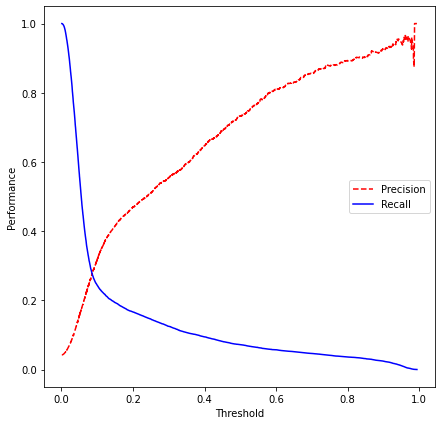

In [67]:
# Threshold-PR curve
precisions, recalls, thresholds = precision_recall_curve(y_true.ravel(), y_prob.ravel())

plt.figure(figsize=(7, 7))
plt.plot(thresholds, precisions[:-1], "r--", label="Precision")
plt.plot(thresholds, recalls[:-1], "b-", label="Recall")
plt.ylabel("Performance")
plt.xlabel("Threshold")
plt.legend(loc="best")
plt.show()

In [68]:
# Determining the best threshold
def find_best_threshold(y_true, y_prob):
    """Find the best threshold for maximum F1."""
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_prob)
    f1s = (2 * precisions * recalls) / (precisions + recalls)
    return thresholds[np.argmax(f1s)]

In [69]:
# Best threshold for f1
threshold = find_best_threshold(y_true.ravel(), y_prob.ravel())
print(threshold)

0.07573042


**How can we do better?**


How can we improve on our process of identifying and using the appropriate threshold?


<details><summary><b> Show answer </b></summary>
<p>

- Plot PR curves for all classes (not just overall) to ensure a certain global threshold doesn't deliver very poor performance for any particular class
- Determine different thresholds for different classes and use them during inference

</p>
</details>

In [70]:
y_true = np.array([y.numpy() for x, y in iter(cnn_test_dataset.unbatch())])
cnn_test_x = cnn_test_dataset.map(lambda x, y: x)
y_prob = cnn_model.predict(cnn_test_x)

# Determine predictions using threshold
y_pred = np.array([np.where(prob >= threshold, 1, 0) for prob in y_prob])

In [71]:
# Evaluate
metrics = precision_recall_fscore_support(y_true, y_pred, average="weighted")
performance = {"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}
print (json.dumps(performance, indent=2))

{
  "precision": 0.2966452787151745,
  "recall": 0.32018711186386,
  "f1": 0.2667923904303416
}


In [72]:
# Save artifacts
dir = Path("cnn")
dir.mkdir(parents=True, exist_ok=True)

# Pickle the tokenizer's config and weights
pickle.dump({'config': text_vectorizer.get_config(),
             'weights': text_vectorizer.get_weights()}, 
             open(f"{dir}/tokenizer.pkl", "wb"))

# Saving model with the SavedModel format
cnn_model.save(f"{dir}/cnn_model", save_format="tf")

# Saving performance metrics
with open(Path(dir, "performance.json"), "w") as fp:
    json.dump(performance, indent=2, sort_keys=False, fp=fp)

INFO:tensorflow:Assets written to: cnn/cnn_model/assets


### Inference

In [73]:
# Load artifacts
from_disk = pickle.load(open(f"{dir}/tokenizer.pkl", "rb"))
tokenizer = L.TextVectorization.from_config(from_disk['config'])

# This might not work for some TF versions
# loaded_cnn_model = tf.keras.models.load_model(f"{dir}/cnn_model")
loaded_cnn_model = cnn_model
loaded_cnn_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 text_vectorization (TextVector  (None, 128)         0           ['text[0][0]']                   
 ization)                                                                                         
                                                                                                  
 embedding (Embedding)          (None, 128, 128)     55552       ['text_vectorization[0][0]']     
                                                                                                  
 conv1d (Conv1D)                (None, 128, 128)     32896       ['embedding[0][0]']          

In [74]:
# Dataloader
text = ["I am loving this amazing MLOps tutorial, so much cool content"]
x_text = get_dataset(text, _, ordered=True, repeated=False, labeled=False)

In [75]:
def decode_preds(preds, labels=labels):
  outputs = []
  for pred in preds:
    decoded = [labels[i] for i, v in enumerate(pred) if v == 1]
    outputs.append(decoded)
  return outputs

In [76]:
y_prob = loaded_cnn_model.predict(x_text)
y_pred = np.array([np.where(prob >= threshold, 1, 0) for prob in y_prob])
print(decode_preds(y_pred))

[['admiration', 'amusement', 'excitement', 'joy', 'love']]


**limitations:**

- **representation:** embeddings are not contextual.
- **architecture:** extracting signal from encoded inputs is limited by filter widths.

> Since we're dealing with simple architectures and fast training times, it's a good opportunity to explore tuning and experiment with k-fold cross validation to properly reach any conclusions about performance.

## Transformers w/ Transfer learning

**motivation:**

- **representation**: now with transformers we have contextual embeddings, and the whole sentence can contribute to the meaning of each word.
- **architecture**: we want to process our encoded inputs using transformers layers and a positional encoder, this setup allows us to feed the complete sentence together as context, instead of as a sequence like we did with the CNN.

![](https://github.com/dimitreOliveira/EmoBERT-MLOps/blob/main/assets/transformer_model.png?raw=true)
> Image source: https://jalammar.github.io/illustrated-transformer/

If you want to know more about transformers and how they work, here are a couple of good sources:
 - [The Illustrated Transformer](https://jalammar.github.io/illustrated-transformer/)
 - [How Transformers work in deep learning and NLP: an intuitive introduction](https://theaisummer.com/transformer/)

### Set up

In [77]:
from transformers import RobertaTokenizerFast, TFRobertaForSequenceClassification

### Tokenizer

With transformers, we will tokenize the inputs not as single characters, as we did previously, now we will tokenize them as sub-words, this is a common approach for transformers and give many advantages.

In [78]:
tokenizer = RobertaTokenizerFast.from_pretrained("arpanghoshal/EmoRoBERTa")

Downloading:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/780k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.68k [00:00<?, ?B/s]

In [79]:
vocab = tokenizer.get_vocab()
print(f"Vocabulary size: {len(vocab)}")
print(list(vocab.items())[:10])

Vocabulary size: 50265
[('Ġorb', 43749), ('Ġdefined', 6533), ('Ġlipstick', 24184), ('ĠBare', 22888), ('NECT', 42849), ('Ġseaf', 33980), ('ĠForge', 35254), ('ĠCase', 11109), ('atern', 36359), ('Ġwaiting', 2445)]


In [80]:
print ("Text to indices:\n"
      f"(preprocessed) → {X_train.iloc[0]}\n"
      f"(tokenized) → {tokenizer(X_train.iloc[0]).input_ids}")

Text to indices:
(preprocessed) → how do you deal with alerts coming up on your phone? i guess you can just turn them off?
(tokenized) → [0, 9178, 109, 47, 432, 19, 5431, 567, 62, 15, 110, 1028, 116, 939, 4443, 47, 64, 95, 1004, 106, 160, 116, 2]


### Datasets

Here we are going to use [TF.data.Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) to efficiently load and process data for training, evaluation, and inference.

In [81]:
def get_dataset_hf(x, y, tokenizer, max_seq_len=max_seq_len, labels=labels, 
                   labeled=True, ordered=False, repeated=True, batch_size=64):
    token_x = tokenizer(x, max_length=max_seq_len, truncation=True, 
                        padding='max_length', return_tensors='tf')

    if labeled:
        dataset = tf.data.Dataset.from_tensor_slices(
            ({'input_ids': token_x['input_ids'], 
              'attention_mask': token_x['attention_mask']}, (y)
            )
        )
    else:
        dataset = tf.data.Dataset.from_tensor_slices(
            {'input_ids': token_x['input_ids'], 
             'attention_mask': token_x['attention_mask']}
        )
  
    if repeated:
        dataset = dataset.repeat()
    if not ordered:
        dataset = dataset.shuffle(2048)
        
    dataset = dataset.batch(batch_size)
    dataset = dataset.cache()
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

In [82]:
# Create datasets
transformer_train_dataset = get_dataset_hf(list(train_df.text), train_df[labels], tokenizer)
transformer_valid_dataset = get_dataset_hf(list(valid_df.text), valid_df[labels], tokenizer, 
                                           ordered=True, repeated=False)
transformer_test_dataset = get_dataset_hf(list(test_df.text), test_df[labels], tokenizer, 
                                          ordered=True, repeated=False)

for sample in transformer_train_dataset.take(1):
    x = sample[0]
    y = sample[1]
    print("Sample point:\n"
    f"  X: {x['input_ids'][0].numpy()}\n"
    f"  y: {y[0]}"
    )
    print("Sample shape:\n"
    f"  X: {x['input_ids'][0].numpy().shape}\n"
    f"  y: {y.shape}"
    )

Sample point:
  X: [   0 1075  571    4   42   16  215   10  372  477  328    2    1    1
    1    1    1    1    1    1    1    1    1    1    1    1    1    1
    1    1    1    1    1    1    1    1    1    1    1    1    1    1
    1    1    1    1    1    1    1    1    1    1    1    1    1    1
    1    1    1    1    1    1    1    1    1    1    1    1    1    1
    1    1    1    1    1    1    1    1    1    1    1    1    1    1
    1    1    1    1    1    1    1    1    1    1    1    1    1    1
    1    1    1    1    1    1    1    1    1    1    1    1    1    1
    1    1    1    1    1    1    1    1    1    1    1    1    1    1
    1    1]
  y: [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
Sample shape:
  X: (128,)
  y: (64, 28)


### Model

In [119]:
transformer_model = TFRobertaForSequenceClassification.from_pretrained("arpanghoshal/EmoRoBERTa")
transformer_model.layers[0].trainable = False
transformer_model.summary()

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at arpanghoshal/EmoRoBERTa.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


Model: "tf_roberta_for_sequence_classification_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 roberta (TFRobertaMainLayer  multiple                 124055040 
 )                                                               
                                                                 
 classifier (TFRobertaClassi  multiple                 612124    
 ficationHead)                                                   
                                                                 
Total params: 124,667,164
Trainable params: 612,124
Non-trainable params: 124,055,040
_________________________________________________________________


### Train

In [120]:
# Arguments
lr = 3e-5
num_epochs = 5
steps_per_epoch = 100
patience = 3

In [121]:
# Define loss & metrics
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics_fn = tf.keras.metrics.BinaryAccuracy()

In [122]:
# Define optimizer & scheduler
optimizer = tf.keras.optimizers.Adam(lr=lr)
scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                 mode='min', factor=0.1, 
                                                 patience=patience, verbose=1)

In [123]:
# Compile model
transformer_model.compile(optimizer=optimizer, 
                          loss=loss_fn, 
                          metrics=metrics_fn)

In [124]:
# Train
with strategy.scope():
    transformer_model.fit(x=transformer_train_dataset, 
                          validation_data=transformer_valid_dataset, 
                          steps_per_epoch=steps_per_epoch, 
                          callbacks=[scheduler], 
                          epochs=num_epochs, 
                          class_weight=class_weights, 
                          verbose=2)

Epoch 1/5
100/100 - 168s - loss: 3.3501e-04 - binary_accuracy: 0.7984 - val_loss: 0.6585 - val_binary_accuracy: 0.8197 - lr: 3.0000e-05 - 168s/epoch - 2s/step
Epoch 2/5
100/100 - 139s - loss: 2.7048e-04 - binary_accuracy: 0.8410 - val_loss: 0.5360 - val_binary_accuracy: 0.8568 - lr: 3.0000e-05 - 139s/epoch - 1s/step
Epoch 3/5
100/100 - 139s - loss: 2.3209e-04 - binary_accuracy: 0.8743 - val_loss: 0.4262 - val_binary_accuracy: 0.8873 - lr: 3.0000e-05 - 139s/epoch - 1s/step
Epoch 4/5
100/100 - 139s - loss: 1.8714e-04 - binary_accuracy: 0.9030 - val_loss: 0.3331 - val_binary_accuracy: 0.9115 - lr: 3.0000e-05 - 139s/epoch - 1s/step
Epoch 5/5
100/100 - 139s - loss: 1.4336e-04 - binary_accuracy: 0.9232 - val_loss: 0.2612 - val_binary_accuracy: 0.9309 - lr: 3.0000e-05 - 139s/epoch - 1s/step


### Evaluation

In [125]:
y_true = np.array([y.numpy() for x, y in iter(transformer_valid_dataset.unbatch())])
transformer_train_x = transformer_valid_dataset.map(lambda x, y: x)
y_prob = transformer_model.predict(transformer_train_x)['logits']

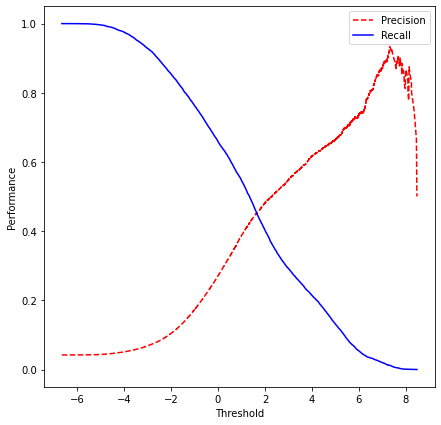

In [126]:
# Threshold-PR curve
precisions, recalls, thresholds = precision_recall_curve(y_true.ravel(), y_prob.ravel())

plt.figure(figsize=(7, 7))
plt.plot(thresholds, precisions[:-1], "r--", label="Precision")
plt.plot(thresholds, recalls[:-1], "b-", label="Recall")
plt.ylabel("Performance")
plt.xlabel("Threshold")
plt.legend(loc="best")
plt.show()

In [127]:
# Best threshold for f1
threshold = find_best_threshold(y_true.ravel(), y_prob.ravel())
print(threshold)

1.3228687


In [128]:
y_true = np.array([y.numpy() for x, y in iter(transformer_test_dataset.unbatch())])
transformer_test_x = transformer_test_dataset.map(lambda x, y: x)
y_prob = transformer_model.predict(transformer_test_x)['logits']

# Determine predictions using threshold
y_pred = np.array([np.where(prob >= threshold, 1, 0) for prob in y_prob])

In [129]:
# Evaluate
metrics = precision_recall_fscore_support(y_true, y_pred, average="weighted")
performance = {"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}
print (json.dumps(performance, indent=2))

{
  "precision": 0.42037631913508383,
  "recall": 0.4977820791999355,
  "f1": 0.4525951067964899
}


In [130]:
# Save artifacts
transformer_dir = Path("transformer")
transformer_dir.mkdir(parents=True, exist_ok=True)

# Saving model with the SavedModel format
transformer_model.save_pretrained(f"{transformer_dir}/transformer_model")

# Saving performance metrics
with open(Path(transformer_dir, "performance.json"), "w") as fp:
    json.dump(performance, indent=2, sort_keys=False, fp=fp)

### Inference

In [131]:
# Load artifacts
loaded_transformer_model = TFAutoModelForSequenceClassification.from_pretrained(f"{transformer_dir}/transformer_model")
loaded_transformer_model.summary()

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at transformer/transformer_model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


Model: "tf_roberta_for_sequence_classification_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 roberta (TFRobertaMainLayer  multiple                 124055040 
 )                                                               
                                                                 
 classifier (TFRobertaClassi  multiple                 612124    
 ficationHead)                                                   
                                                                 
Total params: 124,667,164
Trainable params: 124,667,164
Non-trainable params: 0
_________________________________________________________________


In [132]:
# Dataloader
text = ["I am loving this amazing MLOps tutorial, so much cool content"]
x_text = get_dataset_hf(list(text), _, tokenizer, ordered=True, repeated=False, labeled=False)

In [133]:
y_prob = loaded_transformer_model.predict(x_text).logits
y_pred = np.array([np.where(prob >= threshold, 1, 0) for prob in y_prob])
decode_preds(y_pred)

[['admiration', 'joy']]

# Tradeoffs

We're going to go with the embeddings via CNN approach and optimize it, although the performance is quite worse than the transformers approach, its size and speed are much faster. Later after the MVP or first release version we can switch to the transformers.

In [134]:
# Performance
with open(Path("cnn", "performance.json"), "r") as fp:
    cnn_performance = json.load(fp)
print (f'CNN: f1 = {cnn_performance["f1"]}')

with open(Path("transformer", "performance.json"), "r") as fp:
    transformer_performance = json.load(fp)
print (f'Transformer: f1 = {transformer_performance["f1"]}')

CNN: f1 = 0.2667923904303416
Transformer: f1 = 0.4525951067964899


This was just one run on one split, so you'll want to experiment with k-fold cross validation to properly reach any conclusions about performance. Also make sure you take the time to tune these baselines since their training periods are quite fast. We'll cover optimization in a few lessons, so you can replicate the process here on your own time. We should also benchmark on other important metrics as we iterate, not just precision and recall.

In [135]:
# Size
print (f'CNN: {Path(dir, "cnn_model/saved_model.pb").stat().st_size/1000000:.1f} MB')
print (f'Transformer: {Path(transformer_dir, "transformer_model/tf_model.h5").stat().st_size/1000000:.1f} MB')

CNN: 0.5 MB
Transformer: 499.0 MB


We'll consider other tradeoffs such as maintenance overhead, behavioral test performances, etc. as we develop.

> Interpretability was not one of requirements but note that we could've tweaked model outputs to deliver it. For example, since we used SAME padding for our CNN, we can use the activation scores to extract influential n-grams.

# Resources

- [Backing off towards simplicity - why baselines need more love](https://smerity.com/articles/2017/baselines_need_love.html)
- [Model Evaluation, Model Selection, and Algorithm Selection in Machine Learning](https://arxiv.org/abs/1811.12808)